In [ ]:

# Imports aligned with Streamlit app logic (no Streamlit UI in notebook)
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# TensorFlow / Keras (only what's used)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Statsmodels for Holt-Winters comparison
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [2]:

# Data loading aligned with app (single-index columns)
end = datetime.now().date()
start = end - timedelta(days=365*20)

ticker = "GOOG"  # you can change this

# match app: keep selected OHLCV columns and ensure datetime index
raw = yf.download(ticker, start=start, end=end + timedelta(days=1), auto_adjust=False)
expected_cols = ['Open','High','Low','Close','Adj Close','Volume']
available_cols = [c for c in expected_cols if c in raw.columns]
df = raw[available_cols].copy()
if "Adj Close" in df.columns:
    df.rename(columns={"Adj Close": "Adj_Close"}, inplace=True)
df.index = pd.to_datetime(df.index)

print(df.tail(3))


[*********************100%***********************]  1 of 1 completed

Price             Open        High         Low       Close   Adj_Close  \
Ticker            GOOG        GOOG        GOOG        GOOG        GOOG   
Date                                                                     
2025-09-30  243.059998  243.675003  239.570999  243.550003  243.550003   
2025-10-01  241.179993  247.149994  239.199997  245.539993  245.539993   
2025-10-02  245.639999  247.634995  243.104996  246.429993  246.429993   

Price         Volume  
Ticker          GOOG  
Date                  
2025-09-30  22541200  
2025-10-01  23967700  
2025-10-02  20644500  


In [3]:

# Indicator helpers aligned with app

def add_moving_averages(df, windows=[20,50,100,200]):
    for w in windows:
        df[f"MA_{w}"] = df['Close'].rolling(window=w).mean()
    return df

def add_bollinger_bands(df, window=20, num_std=2):
    ma = df['Close'].rolling(window=window).mean()
    std = df['Close'].rolling(window=window).std()
    df['BB_upper'] = ma + num_std * std
    df['BB_lower'] = ma - num_std * std
    return df

def add_rsi(df, period=14):
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -1 * delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def add_macd(df, fast=12, slow=26, signal=9):
    ema_fast = df['Close'].ewm(span=fast, adjust=False).mean()
    ema_slow = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = ema_fast - ema_slow
    df['MACD_signal'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df


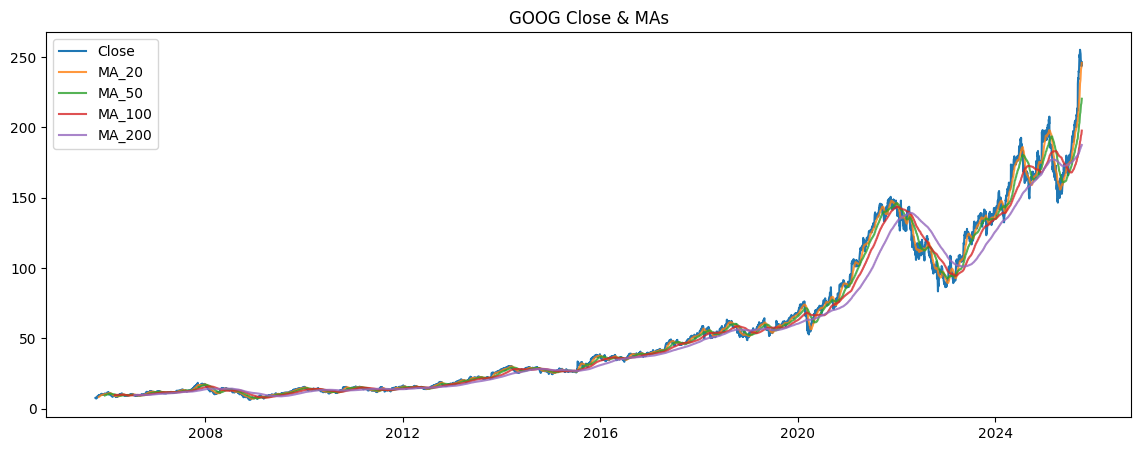

In [4]:

# Compute indicators and quick plots
_df = df.copy()
_df = add_moving_averages(_df)
_df = add_bollinger_bands(_df)
_df = add_rsi(_df)
_df = add_macd(_df)

plt.figure(figsize=(14,5))
plt.plot(_df.index, _df['Close'], label='Close')
for w in [20,50,100,200]:
    col = f"MA_{w}"
    if col in _df.columns:
        plt.plot(_df.index, _df[col], label=col, alpha=0.8)
plt.title(f"{ticker} Close & MAs")
plt.legend()
plt.show()


In [5]:

# Sequence creation and scaling (aligned with app)
lookback = 100
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(_df[['Close']].values)

# create sequences
X, y = [], []
for i in range(lookback, len(scaled)):
    X.append(scaled[i-lookback:i])
    y.append(scaled[i])
X = np.array(X)
y = np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

print(X.shape, y.shape)


(4927, 100, 1) (4927, 1)


In [6]:
# Build and train LSTM model with Dropout and EarlyStopping
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor="loss", patience=3, restore_best_weights=True)
model.fit(X, y, epochs=10, batch_size=16, verbose=1, callbacks=[es])


Epoch 1/10


c:\Users\anand\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


308/308 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 0.0033
Epoch 2/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 9.1211e-04
Epoch 3/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 5.3241e-04
Epoch 4/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 5.5408e-04
Epoch 5/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 4.7457e-04
Epoch 6/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 4.6386e-04
Epoch 7/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 4.3832e-04
Epoch 8/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 4.4786e-04
Epoch 9/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 3.4804e-04
Epoch 10/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 3.0888e-04


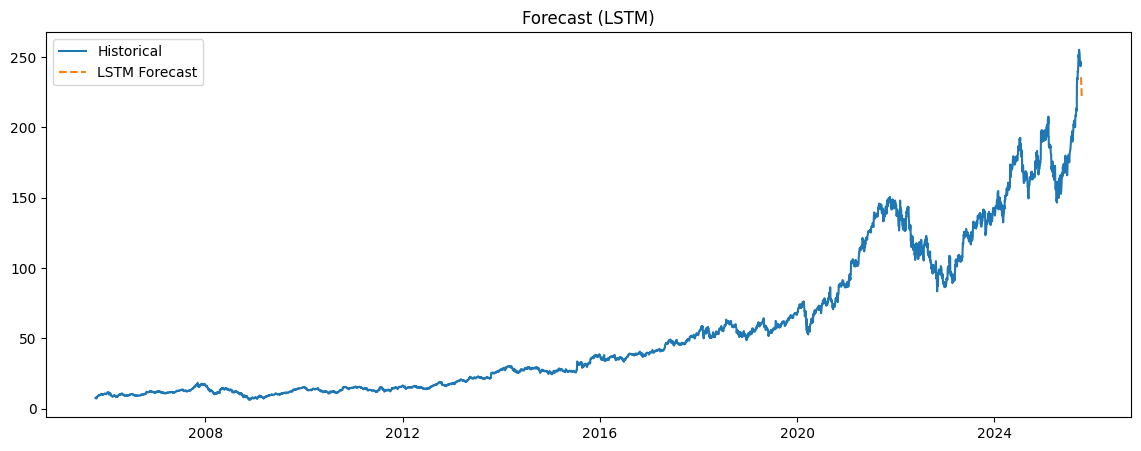

c:\Users\anand\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\anand\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\anand\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\anand\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will res

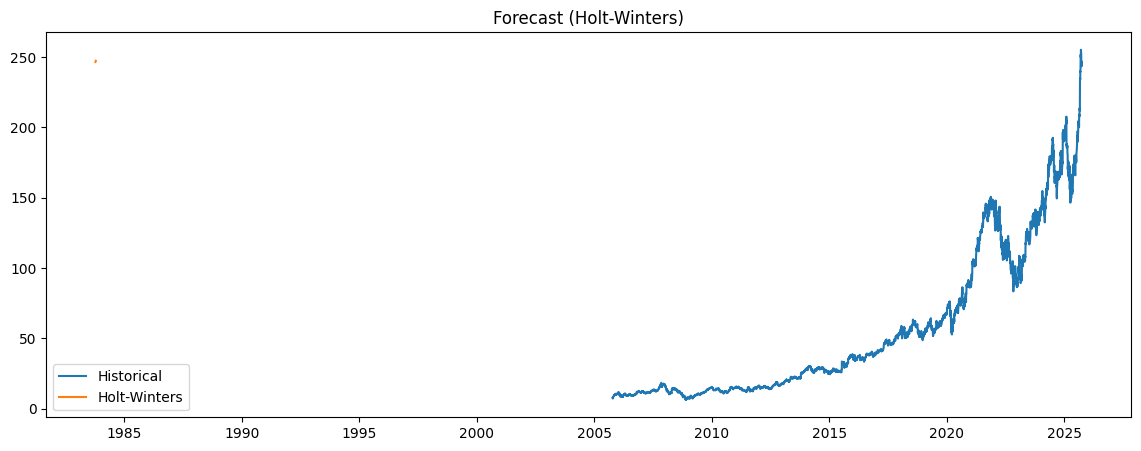

In [7]:

# Multi-step forecast (iterative) and Holt-Winters comparison
forecast_days = 7
last_seq = scaled[-lookback:].reshape(1, lookback, 1)

forecast_scaled = []
current_seq = last_seq.copy()
for _ in range(forecast_days):
    pred = model.predict(current_seq, verbose=0)
    forecast_scaled.append(pred[0,0])
    current_seq = np.append(current_seq[:,1:,:], [[[pred[0,0]]]], axis=1)

forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1,1)).flatten()
forecast_dates = pd.date_range(_df.index[-1] + timedelta(days=1), periods=forecast_days)

plt.figure(figsize=(14,5))
plt.plot(_df.index, _df['Close'], label='Historical')
plt.plot(forecast_dates, forecast, label='LSTM Forecast', linestyle='--')
plt.title('Forecast (LSTM)')
plt.legend()
plt.show()

# Holt-Winters comparison
try:
    hw_model = ExponentialSmoothing(_df['Close'], trend='add', seasonal='add', seasonal_periods=30)
    hw_fit = hw_model.fit()
    hw_forecast = hw_fit.forecast(forecast_days)
    plt.figure(figsize=(14,5))
    plt.plot(_df.index, _df['Close'], label='Historical')
    plt.plot(hw_forecast.index, hw_forecast.values, label='Holt-Winters')
    plt.title('Forecast (Holt-Winters)')
    plt.legend()
    plt.show()
except Exception as e:
    print('Holt-Winters failed:', e)


In [8]:

# Training evaluation metrics on training sequences (like app)
pred_train = model.predict(X, verbose=0)
pred_train_rescaled = scaler.inverse_transform(pred_train)
y_rescaled = scaler.inverse_transform(y.reshape(-1, 1))

mse = mean_squared_error(y_rescaled, pred_train_rescaled)
mae = mean_absolute_error(y_rescaled, pred_train_rescaled)
r2 = r2_score(y_rescaled, pred_train_rescaled)
print({"MSE": mse, "MAE": mae, "R2": r2})


{'MSE': 11.300571367757986, 'MAE': 2.246436716118037, 'R2': 0.9959814200305974}


In [9]:

# Save the trained model to a temp-like path (optional)
# This mirrors app behavior of saving per-ticker; here we use a fixed filename
model_path = f"{ticker}_lstm_notebook.h5"
model.save(model_path)
print("Model saved to:", model_path)


Model saved to: GOOG_lstm_notebook.h5


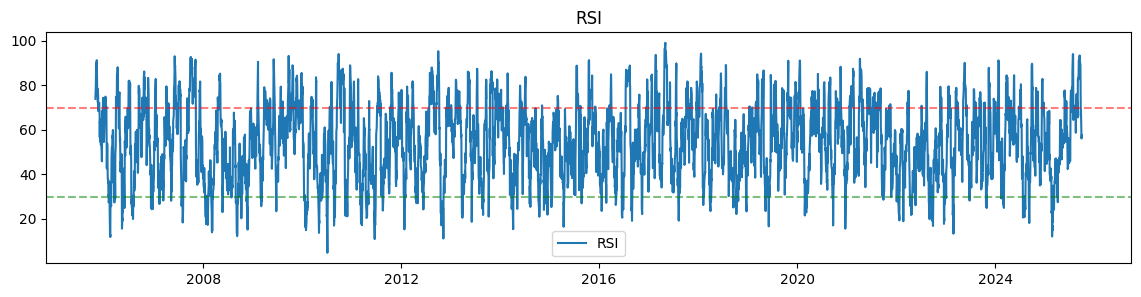

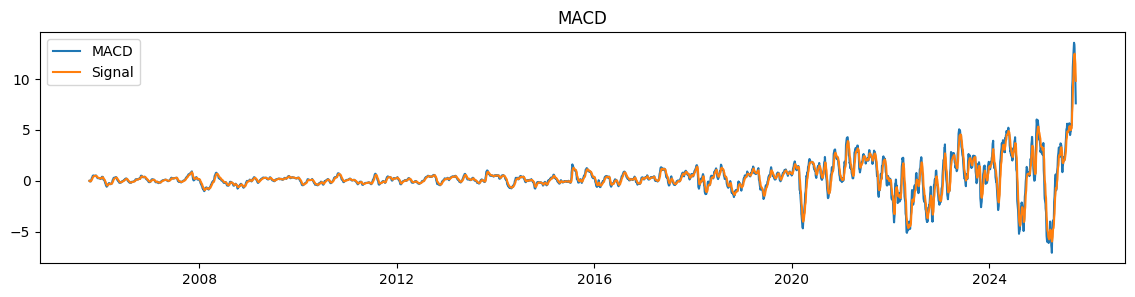

In [10]:

# Optional: Visual check of RSI and MACD
plt.figure(figsize=(14,3))
plt.plot(_df.index, _df['RSI'], label='RSI')
plt.axhline(70, color='r', linestyle='--', alpha=0.5)
plt.axhline(30, color='g', linestyle='--', alpha=0.5)
plt.title('RSI')
plt.legend()
plt.show()

plt.figure(figsize=(14,3))
plt.plot(_df.index, _df['MACD'], label='MACD')
plt.plot(_df.index, _df['MACD_signal'], label='Signal')
plt.title('MACD')
plt.legend()
plt.show()


In [11]:

# Summary: Notebook now mirrors app logic for data, indicators, LSTM, and forecast.
print("Notebook updated to align with web app's modeling flow.")


Notebook updated to align with web app's modeling flow.
